# Solving Sudoku Puzzles Using Grover's Search

In this notebook we will be solving the classic puzzle Sudoku using Grover's search.

We will be basing our algorithm off [this sample](https://github.com/microsoft/Quantum/tree/main/samples/algorithms/sudoku-grover).
Here we adapt the sample to run on actual hardware.
Given that quantum hardware is in the NISQ period right now, we need to minimize qubit count and circuit depth (number of gates) required by the algorithm.

Since Grover's search is fundamentally a quantum algorithm requiring classical preprocessing, we will use the feature of Q# notebooks integrating with python.
This will further enable us to have some convenience in the data structures we build, such as classical validation of Sudoku puzzles.


**IMPORTANT IF RUNNING FROM VSCODE**: Please set the setting `notebook.output.textLineLimit` to at least `2000` to see correct printings of Sudoku puzzles

In [ ]:
import qsharp     # Enable Q#-Python integration

## Defining a Classical Data Structure for Sudoku Puzzles
Let us first write the code to define, validate, and print Sudoku puzzles. This code will be entirely classical and written in Python, serving as an example of integration of classical and quantum code. 
Later we will expand the functionality of the Sudoku class we are defining with quantum computation.

In [ ]:
import math
from copy import deepcopy


class Sudoku:
    data: list = []  # list[list[int]]

    def size(self) -> int:
        """The width/height of the puzzle"""
        return len(self.data)

    def empty_at(self, i: int, j: int) -> bool:
        """Checks if the cell at a given location is empty"""
        return self.at(i, j) == 0

    def at(self, i: int, j: int) -> int:
        """Return the value of a cell at a given location (0 if the cell is empty)"""
        return self.data[i][j]

    def set(self, i: int, j: int, val: int) -> None:
        """Sets the value of a cell at a given location (val=0 will empty the cell)"""
        self.data[i][j] = val

    def __init__(self, data: list) -> None:
        """Initializes the puzzle. 
            data has to be a 2D array of size 4x4 or 9x9 with row-column indexing. 
            Cells marked 0 will be considered empty"""
        size = len(data)
        assert (size in {4, 9})
        # We currently only support Sudoku puzzles up to size 9
        # Larger Sudoku puzzles would require an unreasonable amount of RAM for quantum simulation
        for row in data:
            assert(len(row) == size)
        self.data = deepcopy(data)

    def bit_length(self) -> int:
        """The number of bits required to represent a number in the puzzle"""
        if self.size() == 4:
            return 2
        return 4

    def __str__(self) -> str:
        """Creates a human-readable representation of the puzzle"""
        str = ''
        for row in self.data:
            str += ('-' * (4 * self.size() + 1)) + '\n'
            for el in row:
                if el == 0:
                    str += "|   "
                else:
                    str += f"| {el} "
            str += '|\n'
        str += ('-' * (4 * self.size() + 1)) + '\n'
        return str

    def __eq__(self, __o: object) -> bool:
        if not isinstance(__o, Sudoku):
            return False
        # Compare flattened data
        self_data_flat = [el for row in self.data for el in row]
        o_data_flat = [el for row in __o.data for el in row]
        return self_data_flat == o_data_flat

    def is_valid(self) -> bool:
        """Checks whether the puzzle is complete and meets all Sudoku constraints"""
        # Check for empty cells
        for i in range(self.size()):
            for j in range(self.size()):
                if self.empty_at(i, j):
                    return False

        # Check rows
        for row in range(self.size()):
            values_in_row = set()
            for i in range(self.size()):
                curr = self.at(row, i)
                if curr in values_in_row:
                    return False
                values_in_row.add(curr)
        # Check cols
        for col in range(self.size()):
            values_in_col = set()
            for j in range(self.size()):
                curr = self.at(j, col)
                if curr in values_in_col:
                    return False
                values_in_col.add(curr)
        # Check subgrids
        sub_size = math.floor(math.sqrt(self.size()))

        for sub_grid_i in range(sub_size):
            for sub_grid_j in range(sub_size):
                sub_start_i = sub_grid_i * sub_size
                sub_start_j = sub_grid_j * sub_size
                values_in_sub_grid = set()
                for i in range(sub_start_i, sub_start_i + sub_size):
                    for j in range(sub_start_j, sub_start_j + sub_size):
                        curr = self.at(i, j)
                        if curr in values_in_sub_grid:
                            return False
                        values_in_sub_grid.add(curr)
        # No violations found
        return True

    def count_empty_squares(self) -> int:
        """Returns the number of empty squares in the puzzle"""
        empty = 0
        for i in range(self.size()):
            for j in range(self.size()):
                if self.empty_at(i, j):
                    empty += 1
        return empty


Let's test our code so far.

In [ ]:
sudoku = Sudoku([
                [1, 3, 4, 2],
                [2, 4, 3, 1],
                [3, 2, 1, 4],
                [4, 1, 2, 3]
                ])
print(sudoku)
print("Valid!" if sudoku.is_valid() else "Invalid")


## Sudoku Puzzles as Vertex Coloring Problems

We will use Grover's search to solve Sudoku puzzles by viewing them as a vertex coloring problem: each empty cell of the puzzle is a vertex that needs to have a color assigned based on the constraints imposed by the other cells.

Python pre-processing code converts the input puzzle into a set of constraints and passes it to the quantum part of the program.
Q# code solves the problem defined by the constraints and returns a bitstring that represents the numbers assigned to the empty cells. 
Finally, Python post-processing code parses the solution and validates its correctness.

We represent the integer that will be placed in each empty cell as a bitstring of either two (if $n=2$) or four (if $n=3$) bits, where bitstrings are interpreted as binary integers. 
We then concatenate each cell’s bitstrings, remembering the indices of each empty cell. This means that for a $4 \times 4$ puzzle with $k$ empty cells, we need $2k$ bits for the representation
of the problem.

The algorithm in the quantum component is Grover's search algorithm, an algorithm that prepares a search space and then uses an oracle to perform "Grover iterations".
A "Grover iteration" involves applying an oracle and then diffusion the state.

The amazing thing is that we find the correct results in $\mathcal{O}(\sqrt{k})$

## Classical Precomputation

Let's get building: First we classically create the constraints and then translate them into quantum states.

We classically convert the puzzle into two types of constraints:
- Starting number constraints specify the numbers that cannot be assigned to a cell based on the current nonempty cells.
- Edge constraints specify that any two empty cells that are in the same row, column, or subgrid cannot be assigned the same number.

The figure below shows the constraints of our running example Sudoku puzzle. 
The red borders represent sub-grid borders, the orange numbers are the predefined numbers. 
The black sets are the sets of possible numbers under the starting number constraints - the numbers 1 through 4, except the numbers found in the same row, column, or subgrid as the cell. 
The arrows show the edge constraints.



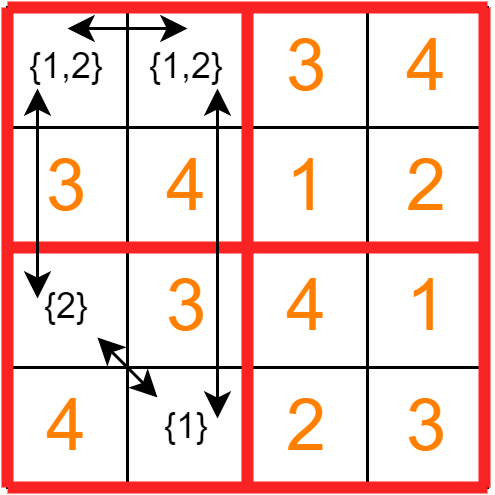



We will encode the constraints as lists. Each empty square of the grid will be assigned an index.
For the pair of empty squares with indices $i, j$ the edge constraint will be expressed by the tuple $(i,j)$ or $(j,i)$.
For an empty square with index $i$ that cannot have value $x$, the starting number constraint will be expressed as $(i,x)$.

The constraint definition code returns a tuple of arrays representing the constraints and the indexed list for mapping indices to empty squares, where the $i^{\text{th}}$ element is the coordinate of the $i^{\text{th}}$ empty square.

In [ ]:
def get_constraints(self) -> tuple: # tuple of: [list[(int, int)], # Empty square edges
                                    #            list[(int, int)], # Starting constraints
                                    #            list[(int, int)]]: # Empty squares
    sub_size = math.floor(math.sqrt(self.size()))
    empty_indices = dict()
    empty_squares = list()
    empty_square_edges = list()
    starting_number_constraints = set()  # We want to avoid duplicates
    empty_index = 0

    for i in range(self.size()):
        for j in range(self.size()):

            # Only consider empty_squares for constraint calculation
            
            if not self.empty_at(i, j):
                continue
            empty_indices[i, j] = empty_index
            empty_squares.append((i, j))

            # Introspect subgrid for constraints 
            # (i.e. the 2x2/3x3 square of the current element)

            i_sub_grid = (i // sub_size) * sub_size
            j_sub_grid = (j // sub_size) * sub_size

            for i_sub in range(i_sub_grid, i_sub_grid + sub_size):
                for j_sub in range(j_sub_grid, j_sub_grid + sub_size):
                    if i_sub == i and j_sub == j:
                        continue
                    if not self.empty_at(i_sub, j_sub):
                        starting_number_constraints.add(
                            (empty_index, self.at(i_sub, j_sub) - 1))
                    elif j_sub < i_sub and i_sub < i and j_sub < j:
                        empty_square_edges.append(
                            (empty_index, empty_indices[(i_sub, j_sub)]))

            # Check for column constraints

            for row_index in range(self.size()):
                if not self.empty_at(row_index, j):
                    starting_number_constraints.add(
                        (empty_index, self.at(row_index, j) - 1))
                elif row_index < i:
                    empty_square_edges.append(
                        (empty_index, empty_indices[(row_index, j)]))

            # Check for row constraints

            for col_index in range(self.size()):
                if not self.empty_at(i, col_index):
                    starting_number_constraints.add(
                        (empty_index, self.at(i, col_index) - 1))
                elif col_index < j:
                    empty_square_edges.append(
                        (empty_index, empty_indices[(i, col_index)]))

            # Exclude illegal values on a 9x9 puzzle
            # Not needed for 4x4 since 4x4 has bit width 2, which only represents legal values

            if self.size() == 9:
                for invalid in range(9, 16):
                    starting_number_constraints.add((empty_index, invalid))

            empty_index += 1
    return (empty_square_edges, list(starting_number_constraints), empty_squares)


Sudoku.get_constraints = get_constraints


## Quantum Code
We have now created our constraints classically. 
Let's convert them into the elements of quantum program.

In the most straightforward approach, we can search through all assignments of integers $[1, n^2]$ to each of the empty cells. In this case, the oracle has to check that the assignment of numbers satisfies both the starting number and the edge constraints.
In the optimized approach, we handle edge constraints and starting number constraints separately. During state preparation, for each cell, we use the starting number constraints to calculate the allowed values and set its qubit representation into uniform superposition of only these values.
The oracle will then only include the checks of the edge constraints.

This drastically reduces search space size. 
In the example above, the search space size shrinks from $4^4=256$ to $4$.
The reduction allows us to use fewer search iterations, resulting in fewer oracle calls, less noise-prone computation, increased performance, and therefore more difficult puzzles we can solve!

Specifically, the optimal number of iterations is given by the formula $i(s) = \lfloor \frac{\pi}{4\arcsin{\sqrt{s^{-1}}}} - \frac{1}{2} \rceil$, where $s$ is the search space size. 
In the example the optimization reduces the number of iterations from $i(256) = 12$ to $i(4) = 1$.
Further, we do not need to encode starting constraints the oracle, significantly lowering the number of qubits required.

But since this is a large project, we'll need to break it down into components:
- Prepare data for the algorithm classically and encode constraints
- Prepare a search state
- An oracle
- Loop over individual iterations
- Measure and extract the information we need


Q# gives us a lot of library features to help us in the process of build our algorithm.

In [ ]:
%%qsharp
open Microsoft.Quantum.Arithmetic;
open Microsoft.Quantum.Arrays;
open Microsoft.Quantum.Convert;
open Microsoft.Quantum.Intrinsic;
open Microsoft.Quantum.Logical;
open Microsoft.Quantum.Math;
open Microsoft.Quantum.Measurement;
open Microsoft.Quantum.Preparation;

In [ ]:
%%qsharp

/// # Summary
/// Encodes stating number constraints into amplitudes.
///
/// # Inputs
/// ## nVertices
/// The number of vertices in the graph.
/// ## bitsPerColor
/// The bit width for number of colors.
/// ## startingNumberConstraints
/// The array of (Vertex#, Color) specifying the disallowed colors for vertices.
///
/// # Examples
/// Consider the case where we have 2 vertices, 2 bits per color, and the constraints (0,1),(0,2),(0,3),(1,2).
/// Then we would get the result where all non-disallowed values have a 1.0 amplitude:
/// [[1.0, 0.0, 0.0, 0.0], 
///  [1.0, 1.0, 0.0, 1.0]]
///
///
/// # Output
/// A 2D array of amplitudes where the first index is the cell and the second index is the value of a basis state (i.e., value) for the cell. =
/// Allowed amplitudes will have a value 1.0, disallowed amplitudes 0.0
function AllowedAmplitudes(
    nVertices : Int,
    bitsPerColor : Int,
    startingNumberConstraints : (Int, Int)[]
) : Double[][] {
    mutable amplitudes = [[1.0, size=1 <<< bitsPerColor], size=nVertices];
    for (cell, value) in startingNumberConstraints {
        set amplitudes w/= cell <- (amplitudes[cell] w/ value <- 0.0);
    }
    return amplitudes;
}

/// # Summary
/// Prepare an equal superposition of all basis states that satisfy the constraints
/// imposed by the digits already placed in the grid.
///
/// # Inputs
/// ## nVertices
/// The number of vertices in the graph.
/// ## bitsPerColor
/// The bit width for number of colors.
/// ## startingNumberConstraints
/// The array of (Vertex#, Color) specifying the disallowed colors for vertices.
///
/// # Remarks
/// Prepares the search space. Using the allowed amplitudes prepares uniform superposition of all allowed values for each cell
operation PrepareSearchStatesSuperposition(
    nVertices : Int,
    bitsPerColor : Int,
    startingNumberConstraints : (Int, Int)[],
    register : Qubit[]
) : Unit is Adj + Ctl {
    // Split the given register into nVertices chunks of size bitsPerColor.
    let colorRegisters = Chunks(bitsPerColor, register);
    // For each vertex, create an array of possible states we're looking at.
    let amplitudes = AllowedAmplitudes(nVertices, bitsPerColor, startingNumberConstraints);
    // For each vertex, prepare a superposition of its possible states on the chunk storing its color.
    for (amps, chunk) in Zipped(amplitudes, colorRegisters) {
        PrepareArbitraryStateD(amps, LittleEndian(chunk));
    }
}

We further use our starting number constraints to calculate the size of the search space, which is just the total number of possible combinations.
With that information we can calculate the number of Grover's iterations we need.

In [ ]:
%%qsharp

/// # Summary
/// Show the size of the search space, i.e. the number of possible combinations
///
/// # Inputs
/// ## nVertices
/// The number of vertices in the graph.
/// ## bitsPerColor
/// The bit width for number of colors.
/// ## startingNumberConstraints
/// The array of (Vertex#, Color) specifying the disallowed colors for vertices.
///
/// # Output
/// The size of the search space (i.e., number of possible combinations)
function SearchSpaceSize(
    nVertices : Int,
    bitsPerColor : Int,
    startingNumberConstraints : (Int, Int)[]
) : Int {
    mutable colorOptions = [1 <<< bitsPerColor, size=nVertices];
    for (cell, _) in startingNumberConstraints {
        set colorOptions w/= cell <- colorOptions[cell] - 1;
    }
    return Fold(TimesI, 1, colorOptions);
}

/// # Summary
/// Estimate the number of iterations required for solution.
///
/// # Input
/// ## searchSpaceSize
/// The size of the search space.
///
/// # Remarks
/// This is correct for an amplitude amplification problem with a single 
/// correct solution, but would need to be adapted when there are multiple
/// solutions
function NIterations(searchSpaceSize : Int) : Int {
    let angle = ArcSin(1. / Sqrt(IntAsDouble(searchSpaceSize)));
    let nIterations = Round(0.25 * PI() / angle - 0.5);
    return nIterations;
}

Let us now build our oracle. We will first build a marking oracle based on our edge constraints and then transform it to a phase oracle.

Our marking oracle operates by marking the states for which each pair of colors connected by an edge constraint is different.
Since the colors are represented by bit strings, we need a separate operation `ApplyColorEqualityOracle` for comparing the colors and marking their equality.

In [ ]:
%%qsharp

/// # Summary
/// N-bit color equality oracle (no extra qubits.)
///
/// # Input
/// ## color0
/// First color.
/// ## color1
/// Second color.
/// ## target
/// Will be flipped if colors are the same.
operation ApplyColorEqualityOracle(
    color0 : Qubit[], color1 : Qubit[],
    target : Qubit
)
: Unit is Adj + Ctl {
    within {
        // compute XOR of q0 and q1 in place (storing it in q1).
        ApplyToEachCA(CNOT, Zipped(color0, color1));
    } apply {
        // if all XORs are 0, the bit strings are equal.
        ControlledOnInt(0, X)(color1, target);
    }
}


/// # Summary
/// Oracle for verifying vertex coloring. Checks that vertices that are related by an edge constraint do not share a value.
/// 
/// 
/// # Input
/// ## nVertices
/// The number of vertices in the graph.
/// ## bitsPerColor
/// The bits per color e.g. 2 bits per color allows for 4 colors.
/// ## edges
/// The array of (Vertex#,Vertex#) specifying the Vertices that can not be
/// the same color.
///
/// # Output
/// An marking oracle that marks as allowed those states in which the colors of qubits related by an edge constraint are not equal.
operation ApplyVertexColoringOracle (
    nVertices : Int, 
    bitsPerColor : Int, 
    edges : (Int, Int)[],
    colorsRegister : Qubit[],
    target : Qubit
)
: Unit is Adj + Ctl {
    let nEdges = Length(edges);
    // we are looking for a solution that has no edge with same color at both ends
    use edgeConflictQubits = Qubit[nEdges];
    within {
        for ((start, end), conflictQubit) in Zipped(edges, edgeConflictQubits) {
            // Check that endpoints of the edge have different colors:
            // apply ApplyColorEqualityOracle oracle;
            // if the colors are the same the result will be 1, indicating a conflict
            ApplyColorEqualityOracle(
                colorsRegister[start * bitsPerColor .. (start + 1) * bitsPerColor - 1],
                colorsRegister[end * bitsPerColor .. (end + 1) * bitsPerColor - 1],
                conflictQubit
            );
        }
    } apply {
        // If there are no conflicts (all qubits are in 0 state), the vertex coloring is valid.
        ControlledOnInt(0, X)(edgeConflictQubits, target);
    }
}

/// # Summary
/// Converts a marking oracle into a phase oracle.
///
/// # Input
/// ## oracle
/// The oracle which will mark the valid solutions.
///
/// # Output
/// A phase oracle that flips the phase of a state, iff the marking oracle marks a state.
operation ApplyPhaseOracle (oracle : ((Qubit[], Qubit) => Unit is Adj),
    register : Qubit[]
)
: Unit is Adj {
    use target = Qubit();
    within {
        // Put the target into the |-⟩ state.
        X(target);
        H(target);
    } apply {
        // Apply the marking oracle; since the target is in the |-⟩ state,
        // flipping the target if the register satisfies the oracle condition
        // will apply a -1 factor to the state.
        oracle(register, target);
    }
    // We put the target back into |0⟩ so we can return it.
}

With what we have now, we can build the main Grover's search algorithm loop.

In [ ]:
%%qsharp

/// # Summary
/// Grover's Algorithm loop.
///
/// # Input
/// ## register
/// The register of qubits.
/// ## oracle
/// The oracle defining the solution we want.
/// ## iterations
/// The number of iterations to try.
///
/// # Remarks
/// Unitary implementing Grover's search algorithm.
operation ApplyGroversAlgorithmLoop(
    register : Qubit[],
    oracle : ((Qubit[], Qubit) => Unit is Adj),
    statePrep : (Qubit[] => Unit is Adj),
    iterations : Int
)
: Unit {
    let applyPhaseOracle = ApplyPhaseOracle(oracle, _);
    statePrep(register);

    for _ in 1 .. iterations {
        applyPhaseOracle(register);
        within {
            Adjoint statePrep(register);
            ApplyToEachA(X, register);
        } apply {
            Controlled Z(Most(register), Tail(register));
        }
    }
}

And the combination of all these components will be the operation `SolvePuzzle` - the entry point to the quantum part of the program.

> To be able to run our code on Azure Quantum, we have to return raw measurement results and convert them to the grid numbers later with classical post-processing code.
>
> We also cannot pass arrays of tuples to our operation using Azure Quantum job arguments. Therefore, we split our tuples arrays into pairs of arrays in the classical code, pass them as input parameters of type `Int[]`, and then zip them again in the Q# code.
>
> If we were just targeting simulation these compromises would not be necessary.

In [ ]:
%%qsharp

/// # Summary
/// Using Grover's search to find vertex coloring.
///
/// # Input
/// ## nVertices
/// The number of Vertices in the graph.
/// ## bitsPerColor
/// The number of bits per color.
/// ## nIterations
/// An estimate of the maximum iterations needed.
/// ## oracle
/// The Oracle used to find solution.
/// ## statePrep
/// An operation that prepares an equal superposition of all basis states in the search space.
///
/// # Output
/// An array giving the color of each vertex.
operation FindColorsWithGrover(
    nVertices : Int, bitsPerColor : Int, nIterations : Int,
    oracle : ((Qubit[], Qubit) => Unit is Adj),
    statePrep : (Qubit[] => Unit is Adj)) : Result[] {

    // Coloring register has bitsPerColor qubits for each vertex
    use register = Qubit[bitsPerColor * nVertices];

    Message($"Trying search with {nIterations} iterations...");
    if (nIterations > 75) {
        Message($"Warning: This might take a while");
    }
    ApplyGroversAlgorithmLoop(register, oracle, statePrep, nIterations);
    return MultiM(register);
}

/// # Summary
/// Solve a Sudoku puzzle using Grover's algorithm.
///
///
/// # Input
/// ## nVertices
/// number of blank squares.
/// ## bitsPerColor
/// The bits per color e.g. 2 bits per color allows for 4 colors.
/// ## emptySquareEdges{1,2}
/// The traditional edges passed to the graph coloring algorithm which, 
/// in our case, are empty puzzle squares.
/// These edges define any "same row", "same column", "same sub-grid" 
/// relationships between empty cells. Due to limitations the tuple list is split.
///
/// ## startingNumberConstraints{1,2}
/// The constraints on the empty squares due to numbers already in the 
/// puzzle when we start. Due to limitations the tuple list is split.
///
/// # Output
/// An array of numbers for each empty square.
///
/// # Remarks
/// The inputs and outputs for the following 4x4 puzzle are:
///    -----------------
///    |   | 1 | 2 | 3 |         <--- empty square #0
///    -----------------
///    | 2 |   | 0 | 1 |         <--- empty square #1
///    -----------------
///    | 1 | 2 | 3 | 0 |
///    -----------------
///    | 3 |   | 1 | 2 |         <--- empty square #2
///    -----------------
///    emptySquareEdges = [(1, 0),(2, 1)]    
///         empty square #0 can not have the same color/number as empty call #1.
///         empty square #1 and #2 can not have the same color/number (same column).
///    startingNumberConstraints = [(0, 2),(0, 1),(0, 3),(1, 1),(1, 2),(1, 0),(2, 1),(2, 2),(2, 3)]
///         empty square #0 can not have values 2,1,3 because same row/column/2x2grid.
///         empty square #1 can not have values 1,2,0 because same row/column/2x2grid.
///    Results = [0,3,0] i.e. Empty Square #0 = 0, Empty Square #1 = 3, Empty Square #2 = 0.
@EntryPoint()
operation SolvePuzzle(
    nVertices : Int, bitsPerColor : Int,
    emptySquareEdges1 : Int[],
    emptySquareEdges2 : Int[],
    startingNumberConstraints1: Int[],
    startingNumberConstraints2: Int[]
) : Result[] {
    let emptySquareEdges = Zipped(emptySquareEdges1, emptySquareEdges2);
    let startingNumberConstraints = Zipped(startingNumberConstraints1, startingNumberConstraints2);
    let oracle = ApplyVertexColoringOracle(nVertices, bitsPerColor, emptySquareEdges, _, _);
    let statePrep = PrepareSearchStatesSuperposition(nVertices, bitsPerColor, startingNumberConstraints, _);
    let searchSpaceSize = SearchSpaceSize(nVertices, bitsPerColor, startingNumberConstraints);
    let numIterations = NIterations(searchSpaceSize);
    Message($"Solving Sudoku puzzle with #Vertex = {nVertices}");
    Message($"   Bits Per Color = {bitsPerColor}");
    Message($"   emptySquareEdges = {emptySquareEdges}");
    Message($"   startingNumberConstraints = {startingNumberConstraints}");
    Message($"   Estimated #iterations needed = {numIterations}");
    Message($"   Search Space Size = {searchSpaceSize}");
    return FindColorsWithGrover(nVertices, bitsPerColor, numIterations, oracle, statePrep);
}

## Classical Postprocessing
Since we can't get the integer results directly from Q#, we will write classical post-processing code to convert the bitstrings we get into integers.

In [ ]:
def chunks(lst: list, n: int) -> list:
    """
    Yield successive n-sized chunks from lst
    """
    for i in range(0, len(lst), n):
        yield lst[i:i + n]


def parse_measured_integer(arr: list) -> int:
    """
    Little endian bit list to integer
    [1,0,1] -> 7
    [0,1,1] -> 6
    [] -> 0
    """
    res = 0
    for i in range(len(arr)):
        if arr[i] != 0:
            res += (2 ** i)
    return res


def parse_measured_integers(arr: list, bit_length: int) -> list:
    """
    Takes a resulting state vector from `SolvePuzzle`, 
    chunks it up into `bit_length` sized chunks and converts each chunk to an integer.
    Returns list of resulting integers
    """
    return list(map(parse_measured_integer, chunks(arr, bit_length)))


def prepare_constraints(self) -> tuple:
    """
    Reshapes constraints to adapt to the limitations of running on Azure Quantum by splitting tuple lists.
    """
    (empty_square_edges, starting_number_constraints,
     empty_squares) = self.get_constraints()
    empty_square_edges_1 = list(map(lambda x: x[0], empty_square_edges))
    empty_square_edges_2 = list(map(lambda x: x[1], empty_square_edges))
    starting_number_constraints_1 = list(
        map(lambda x: x[0], starting_number_constraints))
    starting_number_constraints_2 = list(
        map(lambda x: x[1], starting_number_constraints))
    return (empty_square_edges_1, empty_square_edges_2, starting_number_constraints_1, starting_number_constraints_2, empty_squares)


Sudoku.prepare_constraints = prepare_constraints


Lastly we'll create a function that puts our classical preprocessing, our quantum algorithm, and classical postprocessing together to solve Sudoku puzzles.

In [ ]:

def solve_quantum(self, solve_fn):
    """
    Solve a Sudoku puzzle based on a quantum execution function that 
    takes the parameters for SolveSudoku from the Q# code above 
    and returns an array of the resulting bits
    """
    (empty_square_edges_1, empty_square_edges_2,
     starting_number_constraints_1, starting_number_constraints_2,
     empty_squares) = self.prepare_constraints()
    measurements = solve_fn(nVertices=len(empty_squares),
                            bitsPerColor=self.bit_length(),
                            emptySquareEdges1=empty_square_edges_1,
                            emptySquareEdges2=empty_square_edges_2,
                            startingNumberConstraints1=starting_number_constraints_1,
                            startingNumberConstraints2=starting_number_constraints_2)
    found_solution = isinstance(measurements, list)
    if not found_solution:
        # This will be hit when resource estimation is the case
        print("No solution computed. Did you use resource estimation?")
        return measurements
    print("Solved puzzle!")
    solution = parse_measured_integers(measurements, self.bit_length())
    print(f"Raw solution: {solution}")
    for empty_idx in range(len(empty_squares)):
        (i, j) = empty_squares[empty_idx]
        # Solution range is [0,3] or [0,8], whereas human-readable puzzles work with [1,4] or [1,9], respectively.
        solved_val = solution[empty_idx] + 1
        self.set(i, j, solved_val)


Sudoku.solve_quantum = solve_quantum


## Full State Simulator vs Sparse Simulator

Q# provides two main options for simulating the programs locally: regular ("full state") simulation and sparse simulation.

Since the quantum states used in Grover's search inherently have many zero amplitudes and a lot of entanglement, sparse simulation should perform a lot better. 
Let's try both options and see whether this is the case!

To simulate a Q# operation from Python, you can call `QSharpFunctionName.simulate(params)` or `QSharpFunctionName.simulate_sparse(params)}`, where `params` are named parameters for your Q# operation. 
We handle parameter passing in the `solve_quantum` function above, so all that's left to do is to specify which of the simulation functions we want to use as the `solve_fn` parameter.

Let's use regular and sparse simulation on 4x4 puzzles with few empty spaces to compare the performance of both simulators on this type of problems.

In [ ]:
import time
from IPython.display import clear_output


def run_puzzles(simulator):
    puzzles = [
        [
            [0, 2, 0, 4],
            [3, 0, 0, 2],
            [0, 0, 4, 1],
            [4, 0, 2, 0]
        ],
        [
            [0, 2, 3, 4],
            [3, 4, 1, 2],
            [2, 3, 4, 1],
            [4, 1, 2, 3]
        ],
        [
            [0, 2, 3, 4],
            [3, 0, 1, 2],
            [2, 3, 4, 1],
            [4, 0, 2, 3]
        ],
        [
            [0, 0, 3, 4],
            [0, 0, 1, 2],
            [2, 3, 4, 1],
            [4, 1, 2, 3]
        ]
    ]
    for puzzle in puzzles:
        sudoku = Sudoku(puzzle)
        sudoku.solve_quantum(simulator)
        print(sudoku)
        print("Valid!" if sudoku.is_valid() else "Invalid!")
        if not sudoku.is_valid():
            raise Exception("Invalid solution!")


time_reg_sim = time.time()
run_puzzles(SolvePuzzle.simulate)
time_reg_sim = time.time() - time_reg_sim

time_sparse_sim = time.time()
run_puzzles(SolvePuzzle.simulate_sparse)
time_sparse_sim = time.time() - time_sparse_sim

clear_output(wait=True)  # Remove all the execution printing

print(f"Regular simulator time: {time_reg_sim}s", flush=True)
print(f"Sparse simulator time: {time_sparse_sim}s", flush=True)


We can clearly see that the sparse simulator is two orders of magnitude faster, and this difference will only grow as the program size increases. 
So going forward we will be using it to simulate our code for the larger puzzles. 
Generally speaking, the sparse simulator is often faster than the full state simulator, so make sure to try it when working on your own programs.

## Solving Puzzles With the Sparse Simulator
Below we have a few puzzles of varying difficulty, including a 9x9 puzzle with over 20 empty squares. 
Most puzzles take very little time thanks to the sparse simulator, so you can run them without waiting too much.
The `hard` variable turns on running the "difficult" $4x4$ and $9x9$ puzzles (the ones with 13 or more empty cells), so if you have some spare time, set it to true and see that our solution works for these challenging problems!

In [ ]:
hard = False


puzzles = [
    [  # A base case problem requiring no iterations (3 empty cells)
        [0, 2, 3, 4],
        [3, 0, 1, 2],
        [2, 3, 4, 1],
        [4, 0, 2, 3]
    ],
    [  # This is the most difficult 4x4 puzzle we simulate reasonable quickly (12 empty cells)
        [0, 0, 3, 0],
        [0, 0, 0, 2],
        [0, 0, 4, 0],
        [0, 1, 0, 0]
    ],
    [  # This is the most difficult 4x4 puzzle we can simulate (13 empty cells)
        [0, 0, 0, 0],
        [0, 0, 0, 2],
        [0, 0, 4, 0],
        [0, 1, 0, 0]
    ],
    [  # This is the most difficult 4x4 puzzle we can run on Quantinuum hardware (4 empty cells)
        [0, 0, 3, 4],
        [3, 4, 1, 2],
        [0, 3, 4, 1],
        [4, 0, 2, 3]
    ],
    [  # This is the most difficult 9x9 puzzle we can run on Quantinuum hardware (3 empty cells)
        [6, 0, 3, 8, 9, 4, 5, 1, 2],
        [9, 0, 2, 7, 3, 5, 4, 8, 6],
        [8, 4, 0, 6, 1, 2, 9, 7, 3],
        [7, 0, 8, 2, 6, 1, 3, 5, 4],
        [5, 2, 6, 4, 7, 3, 8, 9, 1],
        [1, 3, 4, 5, 8, 9, 2, 6, 7],
        [4, 6, 9, 1, 2, 8, 7, 0, 5],
        [2, 8, 7, 3, 5, 6, 1, 4, 9],
        [3, 5, 1, 9, 4, 7, 6, 2, 8]
    ],
    [  # This is the most difficult 9x9 puzzle we can simulate (21 empty cells)
        [0, 7, 3, 8, 0, 0, 5, 1, 2],
        [9, 0, 2, 7, 0, 5, 4, 8, 6],
        [8, 4, 5, 0, 0, 0, 0, 0, 0],
        [7, 0, 8, 2, 0, 1, 3, 5, 0],
        [5, 2, 6, 4, 0, 3, 8, 9, 1],
        [1, 3, 4, 5, 0, 0, 0, 0, 0],
        [4, 6, 9, 1, 2, 8, 7, 3, 5],
        [2, 8, 7, 3, 5, 6, 1, 4, 9],
        [3, 5, 1, 9, 4, 7, 6, 0, 8]
    ]
]

for puzzle in puzzles:
    sudoku = Sudoku(puzzle)
    print(sudoku)
    if (not hard) and sudoku.count_empty_squares() > 12:
        print("Skipping hard puzzles")
        continue
    sudoku.solve_quantum(SolvePuzzle.simulate_sparse)
    print(sudoku)
    print("Valid!" if sudoku.is_valid() else "Invalid!")


## Resource Estimation
Seeing that our code solves puzzles correctly, let's get our work ready to run on Azure Quantum targets!
To do that, we need to see what instances would be feasible to run.
For that we will use the resource estimator to see how many resources our computation requires. 

The resources estimator is one of the local simulators provided by the QDK. 
We can reuse our previous code to estimate resources for each puzzle automatically.
The resources consumption will depend on the puzzle instance, its size, and the number and the locations of empty squares.
To see if we can solve a specific puzzle instance on Quantinuum, we check that the number of qubits it requires fits within the number of qubits of the Quantinuum H1-1 system.

In [ ]:
def runs_on_h11(res) -> bool:
    return res['QubitCount'] <= 20


# We'll keep track of which puzzles we can run where!
h11_puzzles = []


for puzzle in puzzles:
    sudoku = Sudoku(puzzle)
    print(sudoku)
    resources = sudoku.solve_quantum(SolvePuzzle.estimate_resources)
    print(resources)
    if runs_on_h11(resources):
        h11_puzzles.append(puzzle)
        print("Can run on Quantinuum H1-1!")


We see that our puzzles have vastly differing qubit requirements. 
These are made up of the following:
* We need $2k$ qubits for our representation of $k$ empty cells
* We need $m$ auxiliary qubits in the oracle for $m$ edge constraints, and one more to convert the marking oracle into the phase one
* We could need some auxiliary qubits to decompose multi-controlled gates into sequences of smaller gates

So, if we see a puzzle with $k$ missing numbers that requires exactly $2k$ qubits, such as the first puzzle from our list, we know that the oracle is never called, and the solution hence amounts to state preparation and measurement. 
The larger puzzles will actually use the oracle to find the best states. 
We can confirm these findings based on the search space sizes that we got during simulation.

With that, let's run some puzzles on Quantinuum through Azure Quantum!


## Running on Quantinuum targets
To run jobs on Azure Quantum we have to connect to our Azure Quantum workspace and locate the Quantinuum targets.

In [ ]:
import qsharp.azure
import datetime

In [ ]:
targets = qsharp.azure.connect(
    resourceId="",
    location=""
)

In [ ]:

print(f"This workspace's {len(targets)} targets:")
for target in targets:
    print(f"- {target.id} (average queue time {datetime.timedelta(seconds=target.average_queue_time)})")


We will now define a function to execute our code on Azure Quantum.
For this we call we will use the `qsharp.azure.submit` function that accepts as input the Q# function, the number of shots, job name, and parameters that will then return a job which we can later get results from.

We will also define a method, where we can get the job results and use those for our computation. 
This is for when we submit to real hardware/emulators which can have hours of queuing time. 
Here we also need a submission function to have our job ready.

In [ ]:
import time
import json
from qsharp.azure import AzureJob

def get_job(job_id) -> tuple:
    current_job = qsharp.azure.status(jobId=job.id)
    succeeded = current_job.status == 'Succeeded'
    if succeeded:
        print(f'Job completed')
    elif current_job.status == 'Failed':
        print(f'Job for this puzzle failed. Please review reason at {job.uri}')
    else:
        print(f'Job for given puzzle is still running. Please check back later!')
    return (succeeded, current_job)

def get_highest_probability_output(output: dict) -> list:
    """
    Goes through outputs from an Azure Quantum job and returns the list with the highest probability
    Returns a list of integers representing the ket notation of the output 
    """
    max_prob = -1
    max_val = ''
    for (val, prob) in output.items():
        if (prob > max_prob):
            max_prob = prob
            max_val = val
    ret = json.loads(max_val)  # convert string rep of list into list type
    return ret


def job_name(self: Sudoku) -> str:
    return f"{self.size()}x{self.size()} Solve Sudoku Puzzle w/ {self.count_empty_squares()} unknowns:\n{str(self)}"


def get_results_from_azure(job_id: str):
    """
    Wrapper function that generates a function pretends execution
    but instead get results from previous execution of a job with id `job_id`
    """
    def get_results_from_azure_with_param(**kwargs) -> list:
        """
        Function to hook into `solve_quantum` method of a `Sudoku` 
        where it gets the job results and return the highest probability result
        """
        output = qsharp.azure.output(jobId=job_id)
        return get_highest_probability_output(output)
    return get_results_from_azure_with_param


def job_msg(job) -> str:
    return f"Submitted job with id {job.id}. Track at {job.uri}"


def submit_job_to_azure(self: Sudoku) -> AzureJob:
    """
    Submits a Sudoku puzzle to be run on Azure asynchronously.
    Return the resulting Azure Quantum job
    """
    (empty_square_edges_1, empty_square_edges_2,
     starting_number_constraints_1, starting_number_constraints_2,
     empty_squares) = self.prepare_constraints()
    nVertices = len(empty_squares)
    job = qsharp.azure.submit(
        SolvePuzzle,
        shots=250,
        jobName=self.job_name(),
        nVertices=nVertices,
        bitsPerColor=self.bit_length(),
        emptySquareEdges1=empty_square_edges_1,
        emptySquareEdges2=empty_square_edges_2,
        startingNumberConstraints1=starting_number_constraints_1,
        startingNumberConstraints2=starting_number_constraints_2
    )
    print(job_msg(job))
    return job


Sudoku.job_name = job_name
Sudoku.submit_job_to_azure = submit_job_to_azure

Let's now run our code on Quantinuum targets. To check that it is compatible with Quantinuum machines, let us first run it on the API validator.

In [ ]:
qsharp.azure.target('quantinuum.hqs-lt-s1-apival')

api_validation_jobs = list()
for puzzle in h11_puzzles:  # We'll be using the puzzles we found viable earlier!
    sudoku = Sudoku(puzzle)
    if not sudoku.count_empty_squares() >= 4:
        continue
    print(sudoku)
    job = sudoku.submit_job_to_azure()
    api_validation_jobs.append(job)


In [ ]:
all_completed = True
for job in api_validation_jobs:
    (completed, _) = get_job(job)
    if not completed:
        all_completed = False
if all_completed:
    # Previous call would throw exception if invalid
    print("API validation succeeded!")


After seeing that everything works smoothly, we will run on the H1-1 emulator.
 
The H1-1 emulator can accurately model the noise of the H1-1 quantum machine, allowing us get good results while staying within our free credits. 
To save on credits we only run the interesting examples of 5 unknowns. 
One of the examples has a search space size of 1, essentially making it state preparation and measurement.
 The other however, has a search space size of 4, causing us to access the Oracle.

**Please note that this sample makes use of paid services on Azure Quantum. 
The cost of running this sample with the provided parameters on Quantinuum in a free trial subscription is approximately 360EHQC (equivalent to 1125$). 
This quantity is only an approximate estimate and should not be used as a binding reference. 
The cost of the service might vary depending on your region, demand and other factors.**

Please note that the jobs might take a while. 
If you are running in the browser on Azure Quantum, please keep the tab open.
If you are running on VSCode, feel free to come back later and load the pickle file.
Feel free to come back later (we saw the average queue time when connecting to Azure Quantum).

In [ ]:
import pickle  # Used to persist current jobs
pkl_filename = "sudoku-quantinuum_jobs.pkl"

In [ ]:
qsharp.azure.target('quantinuum.hqs-lt-s1-sim')
hw_jobs = []
for puzzle in h11_puzzles:
    sudoku = Sudoku(puzzle)
    if not sudoku.count_empty_squares() >= 4:
        continue
    print(sudoku)
    job = sudoku.submit_job_to_azure()
    hw_jobs.append((puzzle, job))
    print(job_msg(job))

# Save current jobs to file, in case you want to come back later
pklfile = open(pkl_filename, 'wb')
pickle.dump(hw_jobs, pklfile)
pklfile.close()


In [ ]:
pklfile = open(pkl_filename, 'rb')
hw_jobs = pickle.load(pklfile)
pklfile.close()


In [ ]:
for (puzzle, job) in hw_jobs:
    sudoku = Sudoku(puzzle)
    print(sudoku)

    sudoku.solve_quantum(get_results_from_azure(job.id))
    print(sudoku)
    print("Valid!" if sudoku.is_valid() else "Invalid")
